## CLIMB Deconvolution - In-Vitro dataset

CLIMB infers cell-subtype proportions through a linear combination of single-cell expression. By aggregating coefficients by cell subtype, it predicts the composition of a cell mix. We generated in vitro pools containing various ratios of HL60, SUDHL4, K562, and THP1 human leukemic cells. We use these pre-determined ratios as ground truth to assess the predictive value of CLIMB deconvolution.

In [8]:
# To install CLIMB, just launch: 
devtools::install_github('alexdray86/CLIMB', force = TRUE)

Skipping 1 packages not available: Biobase



── R CMD build ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
✔  checking for file ‘/private/var/folders/z6/0fzn0d4s1v74_s44tjrc9mg00000gp/T/Rtmp1KqQui/remotes11fd729b580d1/alexdray86-CLIMB-6975f23/DESCRIPTION’
─  preparing ‘climb’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
     NB: this package now depends on R (>= 3.5.0)
     serialize/load version 3 cannot be read in older versions of R.
     File(s) containing such objects:
       ‘climb/data/invitro_bulk_es.RDS’ ‘climb/data/invitro_sc_es.RDS’
─  building ‘climb_0.0.1.tar.gz’
   


In [35]:
# We load CLIMB, Biobase (required for ExpressionSet objects), and ggplot2 (required for making figure)
library(climb) ; library(Biobase) ; library(ggplot2) ; library(reshape2)

In [20]:
# METRICS FUNCTIONS
num <- function(x){ return(as.numeric(as.character(x))) }
rmse <- function(tr, pr){ return( sqrt( sum((tr - pr)^2) / length(tr) ) ) }
pcor <- function(tr, pr){ return( cor(tr, pr, method = 'pearson') ) }

## Load data

We load the data stored as `ExpressionSet` object (library `Biobase` required). We will load the scRNA-seq reference dataset in the object `sc.es` and the bulk RNA-seq from six mixtures in `bulk.es`. 

In [16]:
# We load the two ExpressionSet tables 
devtools::load_all()

ℹ Loading climb


In [24]:
# sc.es is an ExpressionSet object containing our scRNA-seq dataset
sc.es 
dim(sc.es)

ExpressionSet (storageMode: lockedEnvironment)
assayData: 6169 features, 2342 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: AAACAGCCACCGGCTA AAACCAACACCCACAG ... TTTGTTGGTTAGGACC
    (2342 total)
  varLabels: cellType SubjectName
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation:  

Features  Samples 
    6169     2342

In [25]:
# bulk.es is an ExpressionSet object containing our mixtures sequenced with bulk RNA-seq 
bulk.es
dim(bulk.es)

ExpressionSet (storageMode: lockedEnvironment)
assayData: 6169 features, 6 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: BULK1 BULK2 ... BULK6 (6 total)
  varLabels: HL60 K562 SUDHL4 THP1
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation:  

Features  Samples 
    6169        6

In [26]:
# Alternatively, readRDS can be use to load ExpressionSet objects 
# sc.es = readRDS("data/invitro_sc_es.RDS")
# bulk.es = readRDS("data/invitro_bulk_es.RDS")

We load ground truth cell line proportions (based on the volume of homogeneised cells pippeted in the mixture). We have 6 mixtures of cell lines with expression from 6169 genes.

In [27]:
# Load True cell line proportions (based on the volume of homogeneised cells pippeted in the mixture)
true.prop = as.matrix(pData(bulk.es))
true.prop

,HL60,K562,SUDHL4,THP1
BULK1,0.2600,0.0900,0.3300,0.3200
BULK2,0.5700,0.1100,0.0700,0.2500
BULK3,0.3333,0.2222,0.0000,0.4444
BULK4,0.0500,0.0400,0.6100,0.3000
BULK5,0.0198,0.3168,0.1881,0.4752
BULK6,0.1200,0.2600,0.2000,0.4200


## Launch CLIMB deconvolution 

In [28]:
# We use the function climb() from climb package
climb.res = climb(sc.es, bulk.es)

In [29]:
# climb produces a list compose of two results: 1. cell-type abundance, 2. sample-specific cell-type expression
climb.props = climb.res[[1]]
climb.exprs = climb.res[[2]]

No id variables; using all as measure variables

No id variables; using all as measure variables

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


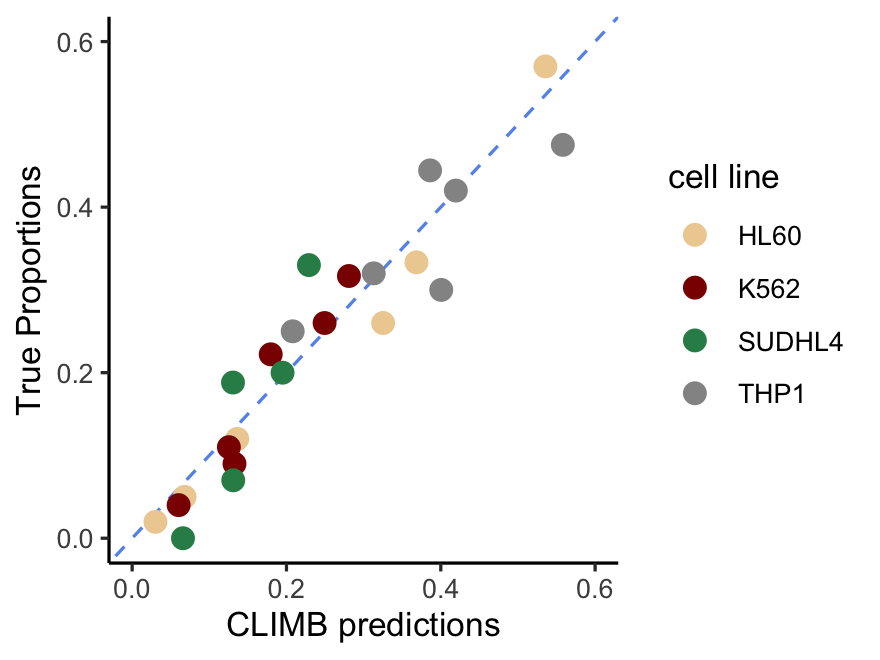

In [31]:
# Plot and display the results 
options(repr.plot.width=4, repr.plot.height=3, repr.plot.res=220)
df_cor = cbind(reshape2::melt(data.frame(true.prop)), 
               reshape2::melt(data.frame(climb.props)))
colnames(df_cor) = c('cell line', 'True Proportions', 'x', 'CLIMB predictions')
g = ggplot(df_cor) + geom_abline(slope=1, linetype = "dashed", colour='cornflowerblue') + 
    geom_point(aes(y=`True Proportions`, x=`CLIMB predictions`, colour=`cell line`), size=3) + theme_classic() + 
    scale_color_manual(values=c('navajowhite2',  'darkred', 'seagreen', 'grey58')) +
    ylab('True Proportions') + xlab('CLIMB predictions') + ylim(0,0.6) + xlim(0,0.6)
g

In this in-vitro experiment, we do not have access to ground truth sample-specific cell-type expression for our 6 mixtures. Nevertheless, we can compare CLIMB predictions of cell-type expression to the average cell-type expression from our scRNA-seq data. 

In [64]:
# True average cell-line expression can be obtained from scRNA-seq
true_ct_expr = aggregate(t(exprs(sc.es)), list(sc.es$cellType), mean)
rownames(true_ct_expr) = true_ct_expr$`Group.1`
true_ct_expr = t(true_ct_expr[,-1])
true_ct_expr = true_ct_expr[,match(colnames(true.prop), colnames(true_ct_expr))]
colnames(true_ct_expr) = colnames(true.prop)
true_ct_expr[is.na(true_ct_expr)] <- 0

In [65]:
# We then combine our predicted expression and scRNA-seq average expression in a single table ready to plot
bulk_mixture_number = 6
melt_pred_expr = cbind(melt(as.matrix(true_ct_expr)), melt(t(climb.exprs[[bulk_mixture_number]])))
melt_pred_expr = melt_pred_expr[,c(1,2,3,6)]
colnames(melt_pred_expr) = c('gene', 'celltype', 'true_expr', 'pred_expr')
head(melt_pred_expr)

,gene,celltype,true_expr,pred_expr
,<fct>,<fct>,<dbl>,<dbl>
1,AAK1,HL60,0.52105263,0.3059467
2,AAMP,HL60,0.28947368,0.8869453
3,AASDH,HL60,0.30000000,0.4434726
4,AASDHPPT,HL60,0.37543860,1.2505807
5,ABCA1,HL60,0.05087719,0.0000000
6,ABCA2,HL60,0.42631579,0.3349476


In [66]:
cor(melt_pred_expr$true_expr, melt_pred_expr$pred_expr)

[1] 0.3570993

Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


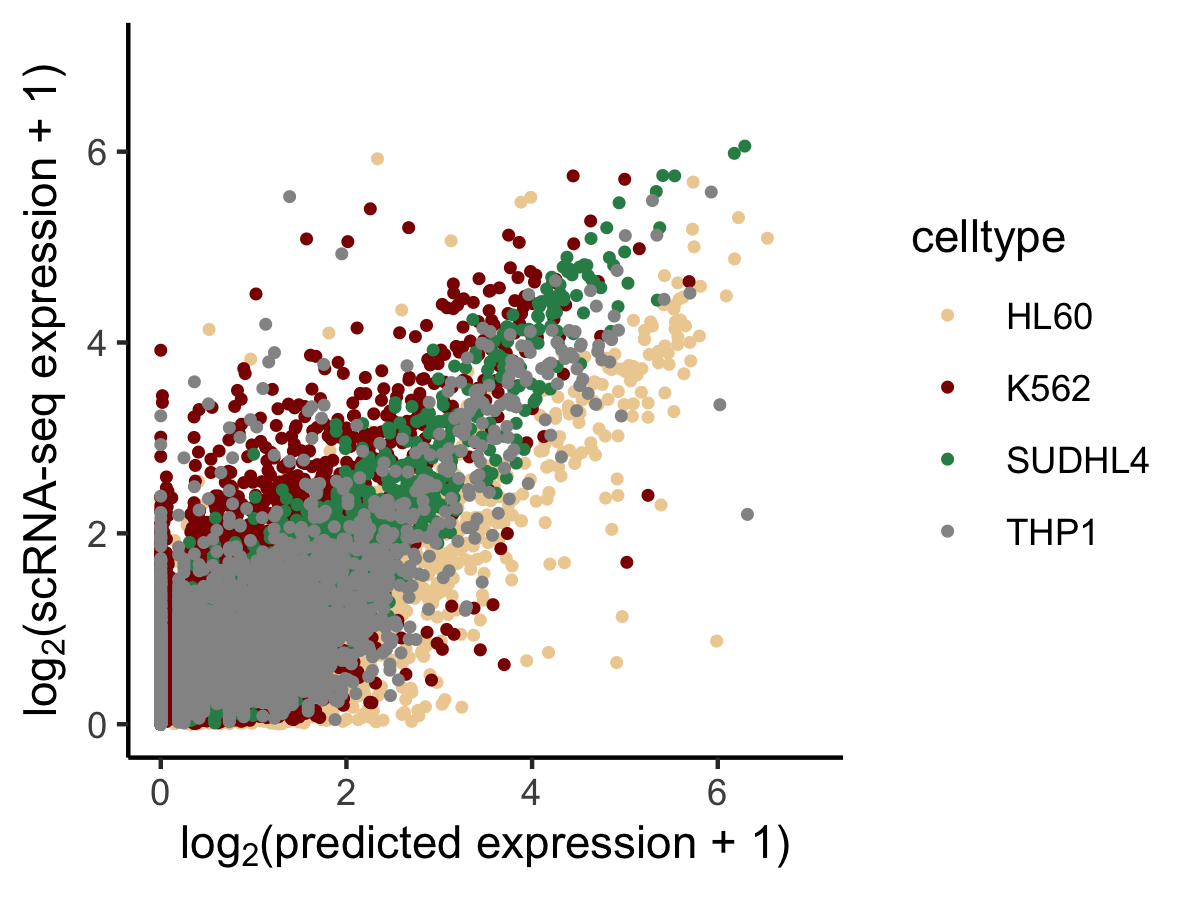

In [76]:
options(repr.plot.width=4, repr.plot.height=3, repr.plot.res=300)
ggplot() + geom_point(data = melt_pred_expr, aes(y=log2(true_expr+1), x=log2(pred_expr+1), color=celltype), size=0.8) + 
    theme_classic() + xlim(0,7) + ylim(0,7) +
    scale_color_manual(values=c('navajowhite2',  'darkred', 'seagreen', 'grey58')) +
    ylab(expression(paste(log[2], '(scRNA-seq expression + 1)'))) + xlab(expression(paste(log[2], '(predicted expression + 1)')))